In [ ]:
%%capture
!pip install stanza

In [ ]:
import pandas as pd

gemini = pd.read_csv("/kaggle/input/samples-new/gemini_sample.csv")
openai = pd.read_csv("/kaggle/input/samples-new/openai_sample.csv")
real_sarc = pd.read_csv("/kaggle/input/samples-new/real_sarc_sample.csv")

In [ ]:
gemini

In [ ]:
import ast

# 'words' column contains strings representing lists
real_sarc['tokens'] = real_sarc['tokens'].apply(ast.literal_eval)
gemini['tokens'] = gemini['tokens'].apply(ast.literal_eval)
openai['tokens'] = openai['tokens'].apply(ast.literal_eval)

In [ ]:
import stanza

uk_nlp = stanza.Pipeline(lang='uk', verbose=False)

def lemmatize(cleared_text):
    lemmas = []
    for sent in uk_nlp(' '.join(cleared_text)).sentences:
        for word in sent.words:
            lemmas.append(word.lemma)
    return lemmas

In [ ]:
print(gemini.groupby('prompting')['num_words'].sum())
print(gemini['num_words'].sum(), end='\n\n')
print(openai.groupby('prompting')['num_words'].sum())
print(openai['num_words'].sum(), end='\n\n')
print(real_sarc.groupby('source')['num_words'].sum(), end='\n\n')
print(real_sarc['num_words'].sum())

In [ ]:
lemmatize(openai['tokens'][3])

In [ ]:
gemini['lemmatized_words'] = gemini['tokens'].apply(lemmatize)
openai['lemmatized_words'] = openai['tokens'].apply(lemmatize)
real_sarc['lemmatized_words'] = real_sarc['tokens'].apply(lemmatize)

In [ ]:
def calculate_statistics(df):
    V_wordforms_unique = len(set(wordform for sublist in df['tokens'] for wordform in sublist))
    V_lemmas_unique = len(set(lemma for sublist in df['lemmatized_words'] for lemma in sublist))
    N_wordforms = sum(len(sublist) for sublist in df['tokens'])
    vocab_richness = V_lemmas_unique / N_wordforms
    avg_word_freq = N_wordforms / V_lemmas_unique
    V1 = sum(1 for sublist in df['tokens'] for wordform in sublist if sum(1 for s in df['tokens'] if wordform in s) == 1)
    richness_for_text = V1 / N_wordforms
    richness_for_vocab = V1 / V_lemmas_unique
    V10 = sum(1 for sublist in df['tokens'] for wordform in sublist if sum(1 for s in df['tokens'] if wordform in s) >= 10)
    concentration_index_text = V10 / N_wordforms
    concentration_index_vocab = V10 / V_lemmas_unique

    return {
        'V_wordforms_unique': round(V_wordforms_unique,3),
        'V_lemmas_unique': round(V_lemmas_unique,3),
        'vocab_richness': round(vocab_richness,3),
        'avg_word_freq': round(avg_word_freq,3),
        'V1': round(V1,3),
        'richness_for_text': round(richness_for_text,3),
        'richness_for_vocab': round(richness_for_vocab,3),
        'V10': round(V10,3),
        'concentration_index_text': round(concentration_index_text,3),
        'concentration_index_vocab': round(concentration_index_vocab, 3)
    }

# Calculate statistics for gemini
gemini_stats = calculate_statistics(gemini)

# Calculate statistics for openai
openai_stats = calculate_statistics(openai)

# Calculate statistics for real_sac
real_sac_stats = calculate_statistics(real_sarc)

In [ ]:
df_stats = pd.DataFrame([gemini_stats, openai_stats, real_sac_stats], index=['gemini', 'openai', 'real_sac'])

df_stats = df_stats.T

df_stats

In [ ]:
# def calculate_attributes(df):
#     # Calculate sum of nouns and ads
#     sum_nouns = sum(1 for pos_list in df['pos_tags'] if 'NOUN' in pos_list)
#     sum_ads = sum(1 for pos_list in df['pos_tags'] if 'ADJ' in pos_list)

#     # Calculate sum of adverbs and verbs
#     sum_adverbs = sum(1 for pos_list in df['pos_tags'] if 'ADV' in pos_list)
#     sum_verbs = sum(1 for pos_list in df['pos_tags'] if 'VERB' in pos_list)

#     # Calculate attributes
#     noun_attribute = sum_nouns / sum_ads if sum_ads != 0 else 0
#     verb_attribute = sum_adverbs / sum_verbs if sum_verbs != 0 else 0
#     nomination_degree = sum_nouns / sum_verbs if sum_verbs != 0 else 0

#     return {
#         'noun_attribute': noun_attribute,
#         'verb_attribute': verb_attribute,
#         'nomination_degree': nomination_degree
#     }

# # Calculate attributes for gemini DataFrame
# gemini_attributes = calculate_attributes(gemini)

# # Calculate attributes for openai DataFrame
# openai_attributes = calculate_attributes(openai)

# # Calculate attributes for real_sac DataFrame
# real_sarc_attributes = calculate_attributes(real_sarc)

# import pandas as pd

# # Create DataFrame from dictionaries
# df_stats = pd.DataFrame([gemini_attributes, openai_attributes, real_sarc_attributes], index=['gemini', 'openai', 'real_sac'])

# # Transpose the DataFrame for better visualization
# df_stats = df_stats.T

# # Display the DataFrame
# df_stats

In [ ]:
%%capture
!python -m spacy download uk_core_news_lg

In [ ]:
import spacy

nlp_uk = spacy.load('uk_core_news_lg')

def ner_search(text):
    doc = nlp_uk(' '.join(text))
    entities = [(ent.text.lower(), ent.label_) for ent in doc.ents]
    return entities

gemini['entities'] = gemini['lemmatized_words'].apply(ner_search)
openai['entities'] = openai['lemmatized_words'].apply(ner_search)
real_sarc['entities'] = real_sarc['lemmatized_words'].apply(ner_search)

In [ ]:
with open("/content/stopwords_ua.txt") as file:
    stops = []
    for word in file.readlines():
        stops.append(word.strip())

In [ ]:
from collections import Counter

def find_entities_or_ngrams(df, column_name):
    all_items = []
    for row in df[column_name]:
        all_items.extend(row)
    item_counts = Counter(all_items)
    total_items = sum(item_counts.values())
    normalized_frequencies = [(item, round(freq / total_items, 5)) for item, freq in item_counts.items()]
    sorted_frequencies = sorted(normalized_frequencies, key=lambda x: x[1], reverse=True)
    return sorted_frequencies

In [ ]:
import nltk
from nltk.util import ngrams

def generate_ngrams(words, n):
    if len(words) >= n:
        return list(ngrams(words, n))
    else:
        return []

In [ ]:
gemini['bigrams'] = gemini['lemmatized_words'].apply(lambda x: generate_ngrams(x, 2))
openai['bigrams'] = openai['lemmatized_words'].apply(lambda x: generate_ngrams(x,  2))
real_sarc['bigrams'] = real_sarc['lemmatized_words'].apply(lambda x: generate_ngrams(x, 2))

In [ ]:
gemini['trigrams'] = gemini['lemmatized_words'].apply(lambda x: generate_ngrams(x, 3))
openai['trigrams'] = openai['lemmatized_words'].apply(lambda x: generate_ngrams(x,  3))
real_sarc['trigrams'] = real_sarc['lemmatized_words'].apply(lambda x: generate_ngrams(x, 3))

In [ ]:
all = find_entities_or_ngrams(gemini, 'bigrams')

In [ ]:
def filter_ngrams_with_no_stops(ngrams, top_n=20):
    filtered_tuples = []
    for tup in ngrams:
        if not any(word in stops for word in tup[0]):
            filtered_tuples.append(tup)
    return sorted(filtered_tuples, key=lambda x: x[1], reverse=True)[:top_n]

In [ ]:
filter_ngrams_with_no_stops(find_entities_or_ngrams(gemini
                                                    , 'entities'))

[(('росія', 'LOC'), 0.5528),
 (('україна', 'LOC'), 0.10559),
 (('путін', 'PER'), 0.0559),
 (('крим', 'LOC'), 0.03727),
 (('реаліт шоя', 'PER'), 0.01863),
 (('сша', 'LOC'), 0.01863),
 (('шоя', 'ORG'), 0.01242),
 (('марс', 'LOC'), 0.01242),
 (('донбас', 'LOC'), 0.01242),
 (('київ', 'LOC'), 0.01242),
 (('євробачення', 'ORG'), 0.01242),
 (('оплот мир', 'PER'), 0.01242),
 (('бог', 'PER'), 0.00621),
 (('поппінс', 'ORG'), 0.00621),
 (('вулиця вітряно', 'LOC'), 0.00621),
 (('джексон', 'PER'), 0.00621),
 (('ілон маска', 'PER'), 0.00621),
 (('англія', 'LOC'), 0.00621),
 (('матюка', 'PER'), 0.00621),
 (('мема', 'PER'), 0.00621)]

In [ ]:
# gemini.to_csv("gemini_sample_lemmatized_ents_ngrams.csv")
# openai.to_csv("openai_sample_lemmatized_ents_ngrams.csv")
# real_sarc.to_csv("real_sarc_sample_lemmatized_ents_ngrams.csv")

In [ ]:
# bigram_frequencies_real_sarc = [(('внутрішній', 'джерело'), 0.00022),
#  (('какая', 'разніца'), 0.00018),
#  (('український', 'мова'), 0.00014),
#  (('голий', 'босий'), 0.00014),
#  (('герой', 'Україна'), 0.00014),
#  (('військовий', 'об’єкт'), 0.00011),
#  (('брати', 'хабар'), 0.00011),
#  (('ракета', 'прилетіти'), 0.00011),
#  (('російський', 'мова'), 0.00011),
#  (('путін', 'напасти'), 0.00011)]

# bigram_frequencies_gemini = [(('нетерпіння', 'чекати'), 0.00402),
#  (('найкращий', 'спосіб'), 0.00185),
#  (('громадський', 'транспорт'), 0.00094),
#  (('радість', 'допомогти'), 0.00087),
#  (('улюблений', 'вид'), 0.00069),
#  (('обожнювати', 'стояти'), 0.00065),
#  (('радість', 'піти'), 0.00065),
#  (('телефон', 'розряджатися'), 0.00062),
#  (('комп’ютер', 'зависати'), 0.00058),
#  (('будильник', 'дзвонити'), 0.00054)]

# bigram_frequencies_openai = [(('п’ять', 'хвилина'), 0.00065),
#  (('останній', 'хвилина'), 0.00061),
#  (('цілий', 'день'), 0.00061),
#  (('електронний', 'лист'), 0.00054),
#  (('сусід', 'вирішити'), 0.0005),
#  (('година', 'пік'), 0.0005),
#  (('найкращий', 'спосіб'), 0.0005),
#  (('вирішити', 'влаштувати'), 0.00047),
#  (('улюблений', 'серіал'), 0.0004),
#  (('чудовий', 'ідея'), 0.0004)]

# entities_real_sarc = [(('україна', 'LOC'), 0.10438),
#  (('зеленський', 'PER'), 0.03608),
#  (('росія', 'LOC'), 0.03351),
#  (('порошенко', 'PER'), 0.02835),
#  (('путін', 'PER'), 0.01933),
#  (('київ', 'LOC'), 0.01804),
#  (('сша', 'LOC'), 0.01675),
#  (('арестович', 'PER'), 0.01546),
#  (('європа', 'LOC'), 0.01289),
#  (('крим', 'LOC'), 0.01289)]

# entities_gemini = [(('росія', 'LOC'), 0.5528),
#  (('україна', 'LOC'), 0.10559),
#  (('путін', 'PER'), 0.0559),
#  (('крим', 'LOC'), 0.03727),
#  (('сша', 'LOC'), 0.01863),
#  (('марс', 'LOC'), 0.01242),
#  (('донбас', 'LOC'), 0.01242),
#  (('київ', 'LOC'), 0.01242),
#  (('євробачення', 'ORG'), 0.01242),
#  (('бог', 'PER'), 0.00621)]

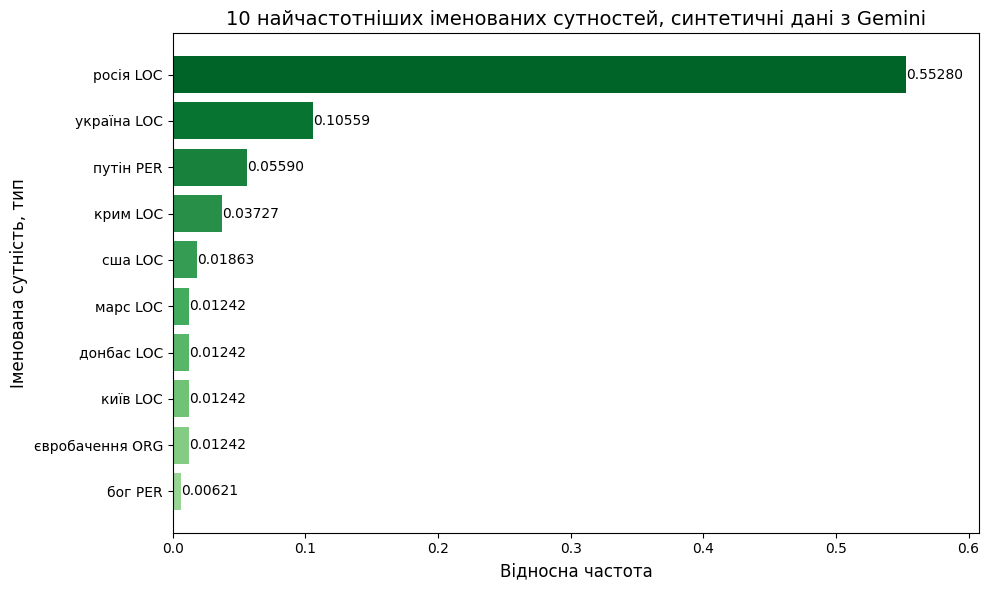

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_top_ngrams_or_entities(object_freq):
  sorted_entities_gemini = sorted(object_freq, key=lambda x: x[1], reverse=True)
  bigrams = [bigram[0] for bigram in sorted_entities_gemini]
  frequencies = [freq for _, freq in sorted_entities_gemini]

  colors = plt.cm.Greens(np.linspace(0.9, 0.4, len(bigrams)))
  # Plotting
  plt.figure(figsize=(10, 6))
  bars = plt.barh(range(len(bigrams)), frequencies, color=colors)
  for i, bar in enumerate(bars):
      plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{frequencies[i]:.5f}',
              va='center', ha='left', fontsize=10, color='black')

  plt.yticks(range(len(bigrams)), [f'{bigram[0]} {bigram[1]}' for bigram in bigrams], fontsize=10)
  plt.xlabel('Відносна частота', fontsize=12)
  plt.ylabel('Іменована сутність, тип', fontsize=12)
  plt.title('10 найчастотніших іменованих сутностей, синтетичні дані з Gemini', fontsize=14)
  plt.gca().invert_yaxis()
  plt.xlim(0, max(frequencies)*1.1)
  plt.xticks(fontsize=10)
  plt.tight_layout()
  plt.show()

plot_top_ngrams_or_entities(entities_gemini)